# Transfer learning for classification of flower images

This notebook is an update from W04L1-1-flowers_transferlearning.ipynb that also incorporates data augmentation.

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
keras.__version__

'2.11.0'

We'll be using a creative-commons licensed 
[flower photo dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) 
of 3670 images falling into 5 categories:
<pre>
'daisy', 'roses', 'dandelion', 'sunflowers', and 'tulips'
</pre>

Please download the following file:
- [flower_photos.zip](https://drive.google.com/file/d/1pZNVfvi9iJRjS6fXFF3om7pp8Gp-AZtM/view?usp=share_link) (220MB)

If you are running this on Google Colab, upload the zipped file to your Google drive, then mount your Google drive using the following code, and copy the file to the base folder:


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp /content/drive/MyDrive/Teaching/COMP3420/flower_photos.zip . 

We then need to unzip the file:

In [5]:
import zipfile

with zipfile.ZipFile('flower_photos.zip', 'r') as zip_ref:
    zip_ref.extractall()

The images are randomly split
into a training set with 90% data and a
test set with 10% data listed in CSV files:

Training set: [train_set.csv](flower_photos/train_set.csv)
Evaluation set: [eval_set.csv](flower_photos/eval_set.csv)


In [6]:
import matplotlib.pylab as plt

# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')


In [7]:
import glob
import os
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = [os.path.basename(l) for l in glob.glob('flower_photos/*') 
               if '.' not in l]

In [8]:
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label


## Data augmentation
Let's define a data augmentation stage to add to an image model. You can find a nice tutorial of two forms to incorporate data augmentation here:

- https://www.tensorflow.org/tutorials/images/data_augmentation

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

## Transfer Learning with MobileNet

Let's load a pre-trained model and use it
instead of the Flattened layer as our first layer. We will use [Tensorflow Hub](https://www.tensorflow.org/hub) to fetch a model implementing MobileNet, pre-trained with the imagenet [imagenet](https://www.image-net.org/) dataset. This dataset contains over 14,197,122 images and 21,841 categories.

If Tensorflow Hub is not installed you will need to install it using this command:

```
pip install --upgrade tensorflow-hub
```

In [ ]:
pip install --upgrade tensorflow-hub

/bin/bash: /home/diego/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       num_hidden = 16,
                       epochs = 10):

  train_dataset = (tf.data.TextLineDataset(
        "flower_photos/train_set.csv").
        map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
        "flower_photos/eval_set.csv").
        map(decode_csv)).batch(batch_size)
  
  model = tf.keras.Sequential(name='flower_classification')

  model.add(keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
  model.add(data_augmentation) # Comment this out to remove data augmentation
  model.add(hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          #input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'))
  model.add(tf.keras.layers.Dense(num_hidden,
                            activation='relu',
                            name='dense_hidden'))
  model.add(tf.keras.layers.Dense(len(CLASS_NAMES), 
                            activation='softmax',
                            name='flower_prob'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=epochs,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])
  training_plot(['loss', 'accuracy'], history)
  return model
  

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10


104/104 [==============================] - 41s 296ms/step - loss: 0.6543 - accuracy: 0.7645 - val_loss: 0.4379 - val_accuracy: 0.8405
Epoch 2/10
104/104 [==============================] - 27s 261ms/step - loss: 0.3656 - accuracy: 0.8748 - val_loss: 0.3796 - val_accuracy: 0.8784
Epoch 3/10
104/104 [==============================] - 26s 245ms/step - loss: 0.2974 - accuracy: 0.8958 - val_loss: 0.3665 - val_accuracy: 0.8784
Epoch 4/10
104/104 [==============================] - 25s 244ms/step - loss: 0.2636 - accuracy: 0.9064 - val_loss: 0.3896 - val_accuracy: 0.8730
Epoch 5/10
104/104 [==============================] - 26s 250ms/step - loss: 0.2419 - accuracy: 0.9161 - val_loss: 0.3530 - val_accuracy: 0.8811
Epoch 6/10
104/104 [==============================] - 25s 243ms/step - loss: 0.2248 - accuracy: 0.9188 - val_loss: 0.3718 - val_accuracy: 0.8784
Epoch 7/10
104/104 [==============================] - 26s 248ms/step - loss: 0.2028 - accuracy: 0.9261 - val_loss: 0.3577 - val_accuracy: 0.8

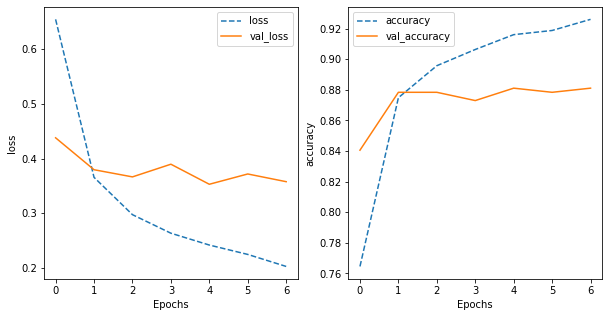

In [11]:
model = train_and_evaluate()

Accuracy on the validation data has increased from 70.81% (AlexNet, trained from scratch) to 88.11%. This is not better than the approach without data augmentation, though. Comment out the line that adds the data augmentation steps to the model and observe the results.

1/1 [==============================] - 0s 27ms/step


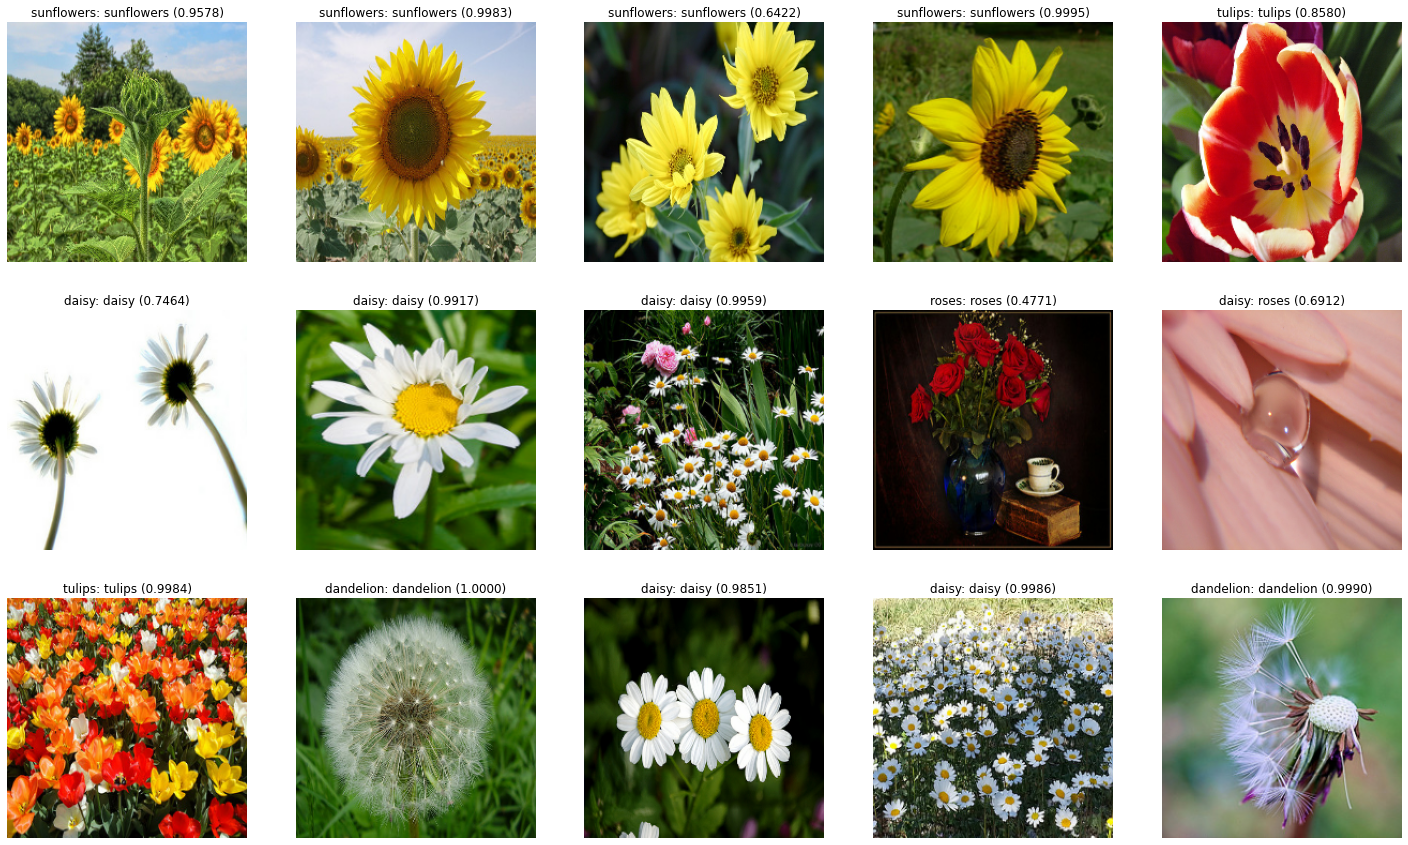

In [12]:
plot_predictions(model, "flower_photos/eval_set.csv")